In [54]:
!pip install basemap
!pip install basemap-data-hires
!pip install geopandas
!pip install openturns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import numpy as np
import pandas as pd
import math
import copy
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from scipy.spatial import ConvexHull
from timeit import default_timer as timer
from datetime import datetime
from datetime import timedelta
import openturns as ot
from openturns.viewer import View

In [57]:
# Boundaries
left_lon = -135
right_lon = -105
upper_lat = 55
lower_lat = 25
spd_constraint = 0.2


In [58]:
date_df = pd.read_csv("/content/drive/My Drive/Database/ENGS103/USA/2021/AIS_2021_01_01/AIS_2021_01_01.csv", encoding='unicode_escape')

In [59]:
date_df = date_df.loc[(right_lon >= date_df['LON']) & (date_df['LON'] >= left_lon) & (upper_lat >= date_df['LAT']) & (date_df['LAT'] >= lower_lat) & (date_df['SOG'] >= 0.2)].dropna(subset=['BaseDateTime','VesselName', 'Length', 'Width', 'Cargo'])
date_df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
25,366983530,2021-01-01T00:00:53,33.73351,-118.16958,0.4,87.1,179.0,JOHN QUIGG,IMO8987929,WDB9828,31.0,0.0,24.0,9.0,4.0,52.0,A
455,367014480,2021-01-01T00:00:53,33.72751,-118.14938,6.1,269.4,511.0,DURANGO,NaN,WDC3807,31.0,0.0,18.0,7.0,NaN,52.0,A
1014,310567000,2021-01-01T00:00:57,32.21392,-117.54706,2.3,110.1,239.0,RUBY PRINCESS,IMO9378462,ZCDY2,60.0,0.0,288.0,36.0,8.5,69.0,A
1496,355433000,2021-01-01T00:00:47,33.70932,-118.19282,0.2,49.2,270.0,NYK CONSTELLATION,IMO9337626,3FCZ6,71.0,1.0,294.0,32.0,11.7,71.0,A
1673,366888800,2021-01-01T00:00:49,32.67153,-117.12713,9.2,338.9,341.0,TIOGA,NaN,WDE7327,52.0,0.0,30.0,12.0,4.2,52.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6613323,338752000,2021-01-01T23:58:20,49.55543,-124.33258,8.5,118.1,115.0,OCEAN RANGER,IMO9010656,WAM7635,31.0,0.0,35.0,9.0,NaN,32.0,A
6613781,548902000,2021-01-01T23:58:35,30.40582,-120.63057,10.3,76.0,69.0,V FULMAR,IMO9296743,DUGR,70.0,0.0,188.0,32.0,12.2,70.0,A
6614232,316012342,2021-01-01T23:59:14,49.21520,-122.89190,10.1,211.0,195.0,KEN MACKENZIE,NaN,NaN,31.0,0.0,12.0,5.0,0.6,31.0,A
6614270,338899000,2021-01-01T23:58:18,48.60944,-122.58303,10.7,332.8,323.0,COMMITMENT,IMO9369411,WDE3894,31.0,0.0,40.0,12.0,6.9,57.0,A


In [60]:
unique_ship = date_df.drop_duplicates(subset=['MMSI'])
unique_ship

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
25,366983530,2021-01-01T00:00:53,33.73351,-118.16958,0.4,87.1,179.0,JOHN QUIGG,IMO8987929,WDB9828,31.0,0.0,24.0,9.0,4.0,52.0,A
455,367014480,2021-01-01T00:00:53,33.72751,-118.14938,6.1,269.4,511.0,DURANGO,NaN,WDC3807,31.0,0.0,18.0,7.0,NaN,52.0,A
1014,310567000,2021-01-01T00:00:57,32.21392,-117.54706,2.3,110.1,239.0,RUBY PRINCESS,IMO9378462,ZCDY2,60.0,0.0,288.0,36.0,8.5,69.0,A
1496,355433000,2021-01-01T00:00:47,33.70932,-118.19282,0.2,49.2,270.0,NYK CONSTELLATION,IMO9337626,3FCZ6,71.0,1.0,294.0,32.0,11.7,71.0,A
1673,366888800,2021-01-01T00:00:49,32.67153,-117.12713,9.2,338.9,341.0,TIOGA,NaN,WDE7327,52.0,0.0,30.0,12.0,4.2,52.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5559740,366993010,2021-01-01T23:18:30,47.56024,-122.34538,7.5,162.3,511.0,WESTRAC,IMO8812849,WTH4325,31.0,0.0,23.0,8.0,4.3,52.0,A
5814329,367741150,2021-01-01T00:57:23,47.59016,-122.34569,0.2,275.8,190.0,CAMERON,NaN,WDI8688,31.0,5.0,28.0,9.0,NaN,32.0,A
6230428,477738600,2021-01-01T13:22:08,33.75652,-118.21418,0.2,264.0,0.0,OOCL LUXEMBOURG,IMO9417270,VRGO3,70.0,5.0,322.0,42.0,14.5,70.0,A
6408685,367349430,2021-01-01T18:23:17,37.79212,-122.28623,0.2,199.1,180.0,PACIFIC FALCON,IMO7200128,WDE4151,31.0,0.0,36.0,9.0,3.9,32.0,A


### Map load

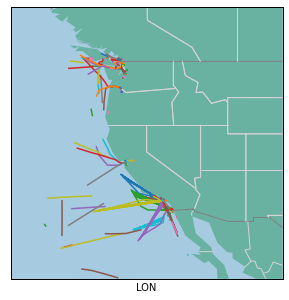

In [61]:
fig, ax = plt.subplots(1,1)

for index, row in unique_ship.iterrows():
  date_df.loc[(date_df['MMSI']==row['MMSI'])].sort_values('BaseDateTime').plot(x='LON', y='LAT', ax=ax, legend=False)

# plot size
plt.rcParams["figure.figsize"]=13,13
m=Basemap(llcrnrlon=left_lon, llcrnrlat=lower_lat, urcrnrlon=right_lon, urcrnrlat=upper_lat)

# Background color:
m.drawmapboundary(fill_color='#A6CAE0')

# background color
m.drawmapboundary(fill_color='#A6CAE0', color="black")

# country color
m.fillcontinents(color='#69b2a2',lake_color='#A6CAE0')
m.drawcountries(color='grey', linewidth=1)

# Show states
m.drawstates(color='lightgrey', linewidth=1)

plt.show()

# Function definitions

## extract data within date of interest 

In [62]:
year = '2021'
date_interest = []
for i in range(1, 16):
  date = str(i)
  if len(date) !=2:
    date = '0' + date
  date_interest.append('2021_01_{}'.format(date))

# date_intrest = ['2021_01_01', '2021_01_02', '2021_01_03', '2021_01_04', '2021_01_05', '2021_01_06', '2021_01_07',]
cargo_type = [70,71,72,73,74,75,76,77,78,79,90,91,92,93,94,95,96,97,98,99]

In [63]:
date_interest

['2021_01_01',
 '2021_01_02',
 '2021_01_03',
 '2021_01_04',
 '2021_01_05',
 '2021_01_06',
 '2021_01_07',
 '2021_01_08',
 '2021_01_09',
 '2021_01_10',
 '2021_01_11',
 '2021_01_12',
 '2021_01_13',
 '2021_01_14',
 '2021_01_15']

In [64]:
def extract_df(date_intrest, cargo_type, left, right, up, down):
  """
  References:
    - AIS vessel type: https://api.vtexplorer.com/docs/ref-aistypes.html

  Args:
    - left: leftmost longitude
    - right: rightmost longitude
    - up: upper latitude
    - down: lower latitude

  Returns:
    - date_df: all information dataframe across dates of interest
    - unique_ship_df: unique ship dataframe across dates  of interest
  """
  # initialization
  date_df = None
  unique_ship_df = None
  
  # each date data extraction
  for idx, date in enumerate(date_intrest):  
    tmp_df = pd.read_csv("/content/drive/My Drive/Database/ENGS103/USA/{}/AIS_{}/AIS_{}.csv".format(year,date, date), encoding='unicode_escape')
    tmp_df = tmp_df.loc[(tmp_df['Cargo'].isin(cargo_type)) & (right >= tmp_df['LON']) & (tmp_df['LON'] >= left) & (up >= tmp_df['LAT']) & (tmp_df['LAT'] >= down) & (tmp_df['SOG'] >= spd_constraint)].dropna(subset=['BaseDateTime','VesselName', 'Length', 'Width', 'Cargo'])
    tmp_unique_ship_df = tmp_df.drop_duplicates(subset=['MMSI'])

    if idx == 0:
      date_df = tmp_df
      unique_ship_df = date_df.drop_duplicates(subset=['MMSI'])
    else:
      date_df = date_df.append(tmp_df)
      unique_ship_df = unique_ship_df.append(tmp_unique_ship_df).drop_duplicates(subset=['MMSI'])

  return date_df.reset_index(), unique_ship_df.reset_index()

In [65]:
# testing
# date_df, unique_ship_df = extract_df(date_interest, cargo_type, left_lon, right_lon, upper_lat, lower_lat)

### plot extracted traffic data field

In [66]:
def plot_port_traffic(port_name, center_lat, center_lon, radius, d_left, d_right, d_up, d_down, date_df, unique_ship_df, anchorage=None, plot=True):
  
  # 1) Initialize plot space
  if plot:
    fig_port, ax_port= plt.subplots(1,1)
    plt.rcParams["figure.figsize"]=10,10

    # color map
    rainbow = cm.get_cmap('rainbow', len(unique_ship_df))
    cmap_space = np.linspace(0.0, 1.0, len(unique_ship_df))

  # 2) Ship track extraction / plot
  for index, row in unique_ship_df.iterrows(): 
    # extract all df per each unique MMSI
    each_ship_df = date_df.loc[(date_df['MMSI']==row['MMSI'])].sort_values('BaseDateTime')

    if plot:
      ax_port.scatter(each_ship_df.LON, each_ship_df.LAT, color=rainbow(cmap_space[index]), s=5, alpha=1)

  # 3) Other plots
  if plot:
    plot_helper(ax_port, center_lat, center_lon, radius, d_left, d_right, d_up, d_down, anchorage)
    plt.show()

In [67]:
def get_base_map(center_lat, center_lon, d_left, d_right, d_up, d_down):
  port_map=Basemap(llcrnrlon=center_lon - d_left, urcrnrlon=center_lon + d_right, urcrnrlat=center_lat + d_up, llcrnrlat=center_lat - d_down)

  # Background color:
  port_map.drawmapboundary(fill_color='#A6CAE0')

  # background color
  port_map.drawmapboundary(fill_color='#A6CAE0', color="black")

  # country color
  port_map.fillcontinents(color='#69b2a2',lake_color='#A6CAE0')
  port_map.drawcountries(color='grey', linewidth=1)

  # Show states
  port_map.drawstates(color='lightgrey', linewidth=1)

  # port_map.drawparallels(np.arange(int(center_lat - d_down),int(center_lat + d_up),0.05),labels=[1,0,0,0])
  # port_map.drawmeridians(np.arange(int(center_lon - d_left),int(center_lon + d_right),0.05),labels=[0,0,0,1])
  port_map.drawmeridians(np.arange(int(center_lat - d_down),int(center_lat + d_up),0.05),labels=[1,0,0,0])
  port_map.drawparallels(np.arange(int(center_lon - d_left),int(center_lon + d_right),0.05),labels=[0,0,0,1])

  return port_map

In [139]:
def plot_helper(ax_port, center_lat, center_lon, radius, d_left, d_right, d_up, d_down, anchorage):
  
  # 3) Base map plot
  port_map = get_base_map(center_lat, center_lon, d_left, d_right, d_up, d_down)

  # 4) Miscellaneous plot
  # 4-1) Port center circle
  cir = plt.Circle((center_lon, center_lat), radius, color='r', alpha=0.2)
  ax_port.add_patch(cir)

  # 4-2) Gateline
  ax_port.plot(
      [gateline_dict[port_name]['start']['LON'], gateline_dict[port_name]['end']['LON']], 
      [gateline_dict[port_name]['start']['LAT'], gateline_dict[port_name]['end']['LAT']], 
      color='k', 
      linewidth=12
      )
  ax_port.set_aspect('equal', adjustable='datalim')

  # 4-3) anchorage
  if anchorage is not None:
    for each_anchorage in anchorage:
      anc_lon = anchorage[each_anchorage]['LON']
      anc_lat = anchorage[each_anchorage]['LAT']
      anc_radius = anchorage[each_anchorage]['radius']
      each_anchor_circle = plt.Circle((anc_lon, anc_lat), anc_radius, color='y', alpha=0.2)
      ax_port.add_patch(each_anchor_circle)

  # plot properties
  ax_port.set_xlim(center_lon - d_left, center_lon + d_right)
  ax_port.set_ylim(center_lat - d_down, center_lat + d_up)

## Arrival data

---
### Anchorage arrival

In [69]:
def extract_arrival_anchorage(port_name, center_lat, center_lon, radius, d_left, d_right, d_up, d_down, date_df, unique_ship_df, anchorage=None, plot=True):
  
  # 1) Initialize plot space
  if plot:
    fig_port, ax_port= plt.subplots(1,1)
    plt.rcParams["figure.figsize"]=10,10

    # color map
    rainbow = cm.get_cmap('rainbow', len(unique_ship_df))
    cmap_space = np.linspace(0.0, 1.0, len(unique_ship_df))

  # 2) Ship track extract / plot
  # each unique ship
  for index, row in unique_ship_df.iterrows(): 
    # extract all data per each unique MMSI
    each_ship_df = date_df.loc[(date_df['MMSI']==row['MMSI'])].sort_values('BaseDateTime').reset_index()

    # check vessel is arriving
    first_time, last_time, last_flag = check_inside_anchorage(each_ship_df, anchorage)
    if first_time is not None and \
      last_time is not None and \
      last_flag is not None and \
      last_flag is True:
        if plot:
          ax_port.scatter(each_ship_df.LON, each_ship_df.LAT, color=rainbow(cmap_space[index]), s=5, alpha=1)

  # 3) Other plots
  if plot:
    plot_helper(ax_port, center_lat, center_lon, radius, d_left, d_right, d_up, d_down, anchorage)
    plt.show()

In [70]:
def check_inside_anchorage(each_ship_df, anchorage):
  """
  function to check a ship is approaching anchorage for arrival process

  Args: 
    - each_ship_df: one specific ship's data frame
    - anchorage information: dictionary

  Return:
    - (first_time, last_time, last_flag): time arriving at anchorage, time last staying moment at anchorage, bool to represent wheter inside anchorage

  """
  for each_anchorage in anchorage:
    anc_lon = anchorage[each_anchorage]['LON']
    anc_lat = anchorage[each_anchorage]['LAT']
    anc_radius = anchorage[each_anchorage]['radius']

  # initialization
  initial_flag = None
  first_time = None
  last_flag = None
  last_time = None

  # ship's dynamic data iteration
  for idx in range(len(each_ship_df)):
    each_ship_lat = each_ship_df.iloc[idx].LAT
    each_ship_lon = each_ship_df.iloc[idx].LON
    each_ship_spd = each_ship_df.iloc[idx].SOG
    each_ship_time = each_ship_df.iloc[idx].BaseDateTime
    distance = math.sqrt((each_ship_lon - anc_lon)**2 + (each_ship_lat - anc_lat)**2)
  
    # 1) initial check whether ship did not yet arrive
    if idx == 0:
      if distance <= anc_radius and each_ship_spd <= 5:
        initial_flag = True
        break # already inside, let's break
  
      else: 
        initial_flag = False
  
    # 2) passing initial time
    else:
      if initial_flag is not None and initial_flag is False: # originally outside of anchorage

        # inside anchorage
        if distance <= anc_radius and each_ship_spd <= 0.5:
          if first_time is None: # first time entering anchorage
            first_time = each_ship_time
          last_flag = True # update enchorage stay
          last_time = each_ship_time

    if idx == len(each_ship_df)-1:
      if distance >= anc_radius:
        return None, None, None
  
  return first_time, last_time, last_flag
    

In [71]:
# LA_unique_ship_df.loc[(LA_unique_ship_df['Heading'] > 270)]

---
### gate line passing

In [72]:
def extract_passing_gate_line(port_name, gateline_dict, center_lat, center_lon, radius, d_left, d_right, d_up, d_down, date_df, unique_ship_df, anchorage=None, interest='arrival', plot=True):
  # 1) Initialize plot space
  if plot:
    fig_port, ax_port= plt.subplots(1,1)
    plt.rcParams["figure.figsize"]=10,10

    # color map
    rainbow = cm.get_cmap('rainbow', len(unique_ship_df))
    cmap_space = np.linspace(0.0, 1.0, len(unique_ship_df))

  # 2) Ship track extraction / plot
  # each unique ship
  count = 0
  for index, row in unique_ship_df.iterrows(): 
    # extract all data per each unique MMSI
    each_ship_df = date_df.loc[(date_df['MMSI']==row['MMSI'])].sort_values('BaseDateTime').reset_index()

    # check vessel is passing gateline
    before_time, after_time = check_crossing_gateline(each_ship_df, gateline_dict, port_name, port_dynamic_info, interest)
    if before_time is not None and after_time is not None:
      print(row['MMSI'], before_time, after_time)
      count += 1

      if plot:
        ax_port.scatter(each_ship_df.LON, each_ship_df.LAT, color=rainbow(cmap_space[index]), s=5, alpha=1)

  print("count {}".format(count))
  
  # 3) Other plots
  if plot:
    plot_helper(ax_port, center_lat, center_lon, radius, d_left, d_right, d_up, d_down, anchorage)
    plt.show()

In [73]:
def check_crossing_gateline(each_ship_df, gateline, port_name, dynamic_info, interest='arrival'):
  """
  function to check a specific ship passes gateline depending on "arrival" or "departure"

  Args:
    - each_ship_df: one specific ship's data frame
    - gateline_dict: gate_line information for all ports
    - portname: port name of interest
    - dynamic_info: movement information (arrival, departure: which direction bound) for all ports
    - interest: extract data of interest, i.e., arrival or departure

  Return:
    - (before_time, after_time): time before pasing the gateline, time after pasing the gateline

  """
  # extract necessary data
  gateline_start_x = gateline[port_name]['start']['LON']
  gateline_start_y = gateline[port_name]['start']['LAT']
  gateline_end_x = gateline[port_name]['end']['LON']
  gateline_end_y = gateline[port_name]['end']['LAT']

  # line equation's slope and y-intercept
  m = (gateline_end_y - gateline_start_y) / (gateline_end_x - gateline_start_x)
  b = gateline_end_y - m * (gateline_end_x)

  # initial parameters
  before_flag = None
  before_time = None
  after_flag = None
  after_time = None

  # each time track per each ship
  for idx in range(len(each_ship_df)):
    # print("ship {}".format(idx))
    each_ship_lat = each_ship_df.iloc[idx].LAT
    each_ship_lon = each_ship_df.iloc[idx].LON
    each_ship_spd = each_ship_df.iloc[idx].SOG
    each_ship_time = each_ship_df.iloc[idx].BaseDateTime

    # regardless of interest: 'arrival' OR 'departure'
    # ------------------------------------------------------------------------------
    # 1. SOUTH-BOUND
    # ------------------------------------------------------------------------------
    if dynamic_info[port_name][interest] == 'Southbound': # North --> South
      # print("here")
      if gateline_start_x <= each_ship_lon <= gateline_end_x:
        # print("here1")
        if before_flag is None and before_time is None:
          if each_ship_lat > m * each_ship_lon + b: # y > mx + b --> above line
            # print("here2")
            before_flag = True
            before_time = each_ship_time

        # before arrival information done
        elif before_flag is True and before_time is not None:
          if each_ship_lat < m * each_ship_lon + b: # y < mx + b --> blow line
            after_flag = True
            after_time = each_ship_time 
            # print("here3")
            break

    # ------------------------------------------------------------------------------
    # 2. NORTH-BOUND
    # ------------------------------------------------------------------------------
    elif dynamic_info[port_name][interest] == 'Northbound': # South --> North
      if gateline_start_x <= each_ship_lon <= gateline_end_x:
        if before_flag is None and before_time is None:
          if each_ship_lat < m * each_ship_lon + b: # y < mx + b --> below line
            before_flag = True
            before_time = each_ship_time

        # before arrival information done
        elif before_flag is True and before_time is not None:
          if each_ship_lat > m * each_ship_lon + b: # y > mx + b --> above line
            after_flag = True
            after_time = each_ship_time 
            # print("here")
            break
    # ------------------------------------------------------------------------------
    # 3. EAST-BOUND
    # ------------------------------------------------------------------------------
    elif dynamic_info[port_name][interest] == 'Eastbound': # West --> East
      if gateline_start_y <= each_ship_lat <= gateline_end_y:
        if before_flag is None and before_time is None:
          if each_ship_lat > m * each_ship_lon + b: # y > mx + b --> above line
            before_flag = True
            before_time = each_ship_time

        # before arrival information done
        elif before_flag is True and before_time is not None:
          if each_ship_lat < m * each_ship_lon + b: # y < mx + b --> below line 
            after_flag = True
            after_time = each_ship_time 
            # print("here")
            break

    # ------------------------------------------------------------------------------
    # 4. WEST-BOUND
    # ------------------------------------------------------------------------------
    else: # Westbound   # East --> West
      if gateline_start_y <= each_ship_lat <= gateline_end_y:
        if before_flag is None and before_time is None:
          if each_ship_lat < m * each_ship_lon + b: # y < mx + b --> below line  
            before_flag = True
            before_time = each_ship_time

        # before arrival information done
        elif before_flag is True and before_time is not None:
          if each_ship_lat > m * each_ship_lon + b: # y > mx + b --> above line
            after_flag = True
            after_time = each_ship_time 
            # print("here")
            break  

  # print(before_time, after_time)
  return before_time, after_time

## Extract arrival information

In [74]:
def extract_arrival_info(port_name, gateline_dict, date_df, unique_ship_df, anchorage=None):

  # 0. initialization  
  # arrival_info_df = pd.DataFrame(columns=['MMSI', 'anchor_start_time', 'arrival_passing_time', 'departure_passing_time']).reset_index()
  arrival_info_df = None

  # 11 Ship track arrival info extraction

  for index, row in unique_ship_df.iterrows(): 
    # extract all data per each unique MMSI
    each_ship_df = date_df.loc[(date_df['MMSI']==row['MMSI'])].sort_values('BaseDateTime').reset_index()

    # 1). check anchorage arrival time
    anchor_first_time, anchor_last_time, last_flag = None, None, None
    if anchorage is not None:
      anchor_first_time, anchor_last_time, last_flag = check_inside_anchorage(each_ship_df, anchorage)
    # 2). check vessel is passing gateline for arrival
    arr_before_time, arr_after_time = check_crossing_gateline(each_ship_df, gateline_dict, port_name, port_dynamic_info, 'arrival')
    # 3). check vessel is passing gateline for departure
    dep_before_time, dep_after_time = check_crossing_gateline(each_ship_df, gateline_dict, port_name, port_dynamic_info, 'departure')

    if index == 0:
      arrival_info_df = pd.DataFrame({"MMSI":[row['MMSI']],
                          "anchor_start_time":[anchor_first_time], 
                          "anchor_last_time": [anchor_last_time],
                          "arrival_passing_time":[arr_after_time],
                          "departure_passing_time":[dep_after_time],
                          })
    else:
      # print("MMSI {} anc_s {} anc_e {} arr {} dep {}".format(row['MMSI'], anchor_first_time, anchor_last_time, arr_after_time, dep_after_time))
      tmp_df = pd.DataFrame({"MMSI":[row['MMSI']],
                          "anchor_start_time":[anchor_first_time], 
                          "anchor_last_time": [anchor_last_time],
                          "arrival_passing_time":[arr_after_time],
                          "departure_passing_time":[dep_after_time],
                          })
      arrival_info_df = arrival_info_df.append(tmp_df, ignore_index=True)

  # None to NaN mapping
  arrival_info_df.replace(to_replace=[None], value=np.nan, inplace=True)
  # clean up rows with all NaNs at time
  # https://stackoverflow.com/questions/23743460/replace-none-with-nan-in-pandas-dataframe
  arrival_info_df = arrival_info_df.dropna(axis=0, subset=('anchor_start_time', "anchor_last_time", 'arrival_passing_time', 'departure_passing_time'), how='all').reset_index()
  return arrival_info_df

## Find arrival distribution

In [172]:
def find_arrival_distribution(start_time_obj, end_time_obj, arrival_info_df, anchor_contain=True, plot=True):
  current_time_obj = start_time_obj
  dict_observation = dict()

  while current_time_obj <= end_time_obj:
    current_time_str = current_time_obj.strftime('%Y-%m-%d{}%H:%M:%S'.format("T"))
    next_time_obj = current_time_obj + time_increment
    next_time_str = (next_time_obj).strftime('%Y-%m-%d{}%H:%M:%S'.format("T"))

    # observed number of ships calling during the time interval
    if anchor_contain:
      arr_observation = len(arrival_info_df.loc[
                        ((arrival_info_df['anchor_start_time'] >= current_time_str) &  (arrival_info_df['anchor_start_time'] <= next_time_str)) | 
                        ((arrival_info_df['arrival_passing_time'] >= current_time_str) &  (arrival_info_df['arrival_passing_time'] <= next_time_str))])
    else:
      arr_observation = len(arrival_info_df.loc[ 
                        (arrival_info_df['arrival_passing_time'] >= current_time_str) &  (arrival_info_df['arrival_passing_time'] <= next_time_str)])

    if arr_observation not in dict_observation.keys():
      dict_observation[arr_observation] = 1 # count 
    else: # already happend
      dict_observation[arr_observation] += 1

    # print(current_time_obj)
    current_time_obj = next_time_obj
  
  if plot: 
    fig_dist, ax_dist = plt.subplots(1,1)
    plt.rcParams["figure.figsize"]=5,5
    plt.bar(*zip(*dict_observation.items()))
    plt.xticks(np.arange(min(dict_observation.keys()), max(dict_observation.keys())+1, 1.0))
    plt.xlabel("number of ships")
    plt.ylabel("observations")
    plt.show()
    
  return dict_observation

### Chi-square fitness test
reference: 
  * https://stackoverflow.com/questions/24371051/how-to-perform-a-chi-squared-goodness-of-fit-test-using-scientific-libraries-in
  * https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.viewer.View.html
  * https://openturns.github.io/openturns/1.17/user_manual/_generated/openturns.FittingTest_ChiSquared.html

In [76]:
def test_fitness(port_observation):
  ret = np.array([])
  for key, val in port_observation.items():
    ret = np.append(ret, np.ones(val) * key)
  sample = ot.Sample([[p] for p in ret])
  distribution = ot.PoissonFactory().build(sample)

  result = ot.FittingTest.ChiSquared(sample, distribution, 0.01)
  print('Poisson?', result.getBinaryQualityMeasure(), ', P-value=', result.getPValue())
  print(distribution)
  return distribution

# Data analysis
---

## Parameters

In [77]:
# reference: ERDC/CHL TR-17-2 "Tidal analysis and arrival process mining using Automatic Identification System (AIS) data"

gateline_dict = {'Long_Beach': {'start':{'LAT':33.7230, 'LON':-118.1932}, 'end':{'LAT':33.7226, 'LON': -118.1726}},
                 'Los_Angeles': {'start':{'LAT':33.7080, 'LON':-118.2544}, 'end':{'LAT':33.7134, 'LON': -118.2370}},
                 'Seattle': {'start':{'LAT':47.6602, 'LON': -122.5190}, 'end':{'LAT':47.6535, 'LON':-122.4064}},
                 'Tacoma': {'start':{'LAT':47.6602, 'LON': -122.5190}, 'end':{'LAT':47.6535, 'LON':-122.4064}},
                 'San_Francisco': {'start':{'LAT':37.8094, 'LON':-122.4770}, 'end':{'LAT':37.8268, 'LON': -122.4800}}
                 }
                 
port_dynamic_info = {
    'Los_Angeles': {'arrival': 'Northbound', 'departure': 'Southbound'},
    'Long_Beach': {'arrival': 'Northbound', 'departure': 'Southbound'},
    'Tacoma': {'arrival': 'Southbound', 'departure': 'Northbound'},
    'Seattle': {'arrival': 'Southbound', 'departure': 'Northbound'},
    'San_Francisco': {'arrival': 'Eastbound', 'departure': 'Westbound'},
    }

In [174]:
# time setting
start_time = '2021-01-01T00:00:00'
end_time = '2021-01-16T00:00:00'
# end_time = '2021-01-08T00:00:00'
time_increment = timedelta(hours=12)

start_time_obj = datetime.strptime(start_time, '%Y-%m-%d{}%H:%M:%S'.format("T")) # str to obj
end_time_obj = datetime.strptime(end_time, '%Y-%m-%d{}%H:%M:%S'.format("T")) 
start_time_str = start_time_obj.strftime('%Y-%m-%d{}%H:%M:%S'.format("T")) # obj to str
end_time_str = (start_time_obj + time_increment).strftime('%Y-%m-%d{}%H:%M:%S'.format("T"))

## 1. Port of Los Angeles

### 1-1. Get data

In [79]:
# Center Coordinate
port_name = 'Los_Angeles'
lat_Los_Angeles = 33.7292
lon_Los_Angeles = -118.2620

anchorage_Los_Angeles = {
    'B-7': {'LAT': lat_Los_Angeles-0.05, 'LON': lon_Los_Angeles + 0.09, 'radius': 0.05},
}

# anghorage info
# https://www.law.cornell.edu/cfr/text/33/110.214

In [80]:
# ship information within rectangular bound
LA_df, LA_unique_ship_df = extract_df(date_interest, 
                                      cargo_type, 
                                      lon_Los_Angeles - 0.15, 
                                      lon_Los_Angeles + 0.15, 
                                      lat_Los_Angeles + 0.1, 
                                      lat_Los_Angeles - 0.1)

In [81]:
LA_unique_ship_df["Length"].mean()

260.5147058823529

### 1-2. plot entire data

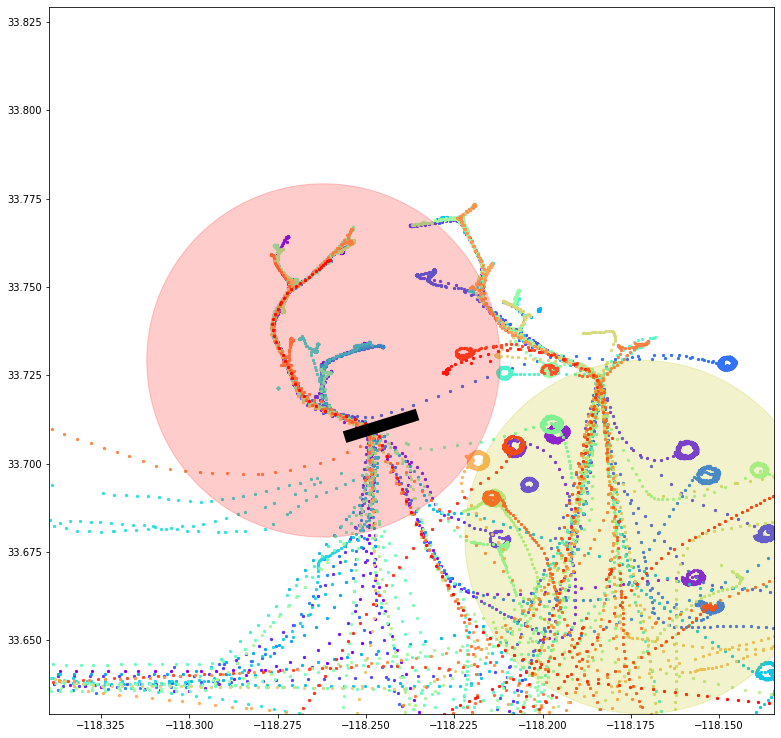

In [82]:
# plot harbor
plot_port_traffic('Los_Angeles', 
                  lat_Los_Angeles, 
                  lon_Los_Angeles, 
                  radius=0.05, 
                  d_left=0.05, 
                  d_right=0.1, 
                  d_up=0.1, 
                  d_down=0.1, 
                  date_df=LA_df, 
                  unique_ship_df=LA_unique_ship_df, 
                  anchorage = anchorage_Los_Angeles )

### 1-3. Arrival by passing gate line

636018560 2021-01-04T02:42:10 2021-01-04T02:51:10
212348000 2021-01-03T11:50:02 2021-01-03T12:03:24
235098885 2021-01-03T03:58:21 2021-01-03T04:04:42
416495000 2021-01-07T19:35:05 2021-01-07T19:45:34
352822000 2021-01-07T19:28:02 2021-01-07T19:37:22
352375000 2021-01-01T03:00:09 2021-01-01T22:36:10
303352000 2021-01-05T15:04:33 2021-01-05T15:12:15
367395280 2021-01-06T07:30:14 2021-01-07T20:28:28
563433000 2021-01-04T07:34:39 2021-01-09T21:00:02
636018222 2021-01-12T12:45:51 2021-01-12T12:50:20
636019717 2021-01-06T12:02:15 2021-01-06T12:09:04
218092000 2021-01-05T22:59:48 2021-01-05T23:08:17
477655900 2021-01-06T12:26:34 2021-01-06T12:36:45
311045300 2021-01-11T04:49:33 2021-01-11T04:58:46
367492920 2021-01-11T08:06:56 2021-01-11T22:10:29
636016038 2021-01-12T11:10:28 2021-01-12T11:22:57
372724000 2021-01-15T12:22:57 2021-01-15T12:32:01
count 17


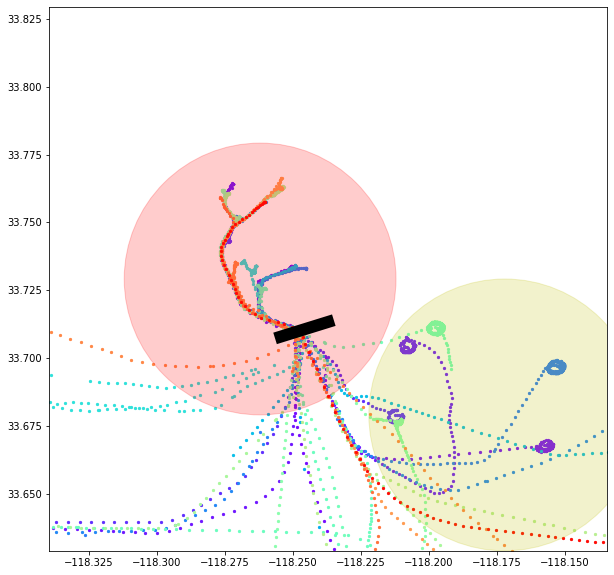

In [83]:
extract_passing_gate_line('Los_Angeles', 
                          gateline_dict,
                          lat_Los_Angeles, 
                          lon_Los_Angeles, 
                          radius=0.05, 
                          d_left=0.05, 
                          d_right=0.1, 
                          d_up=0.1, 
                          d_down=0.1, 
                          date_df=LA_df, 
                          unique_ship_df=LA_unique_ship_df, 
                          anchorage = anchorage_Los_Angeles, 
                          interest='arrival')

### 1-4 Arrival at anchorage

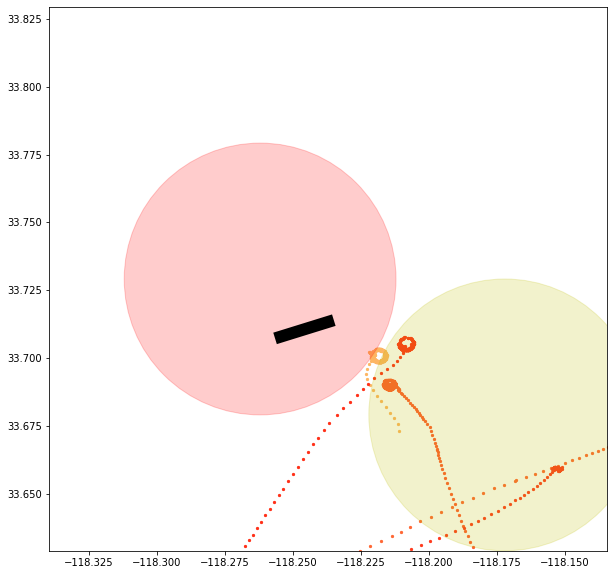

In [84]:
extract_arrival_anchorage('Los_Angeles', 
                          lat_Los_Angeles, 
                          lon_Los_Angeles, 
                          radius=0.05, 
                          d_left=0.05, 
                          d_right=0.1, 
                          d_up=0.1, 
                          d_down=0.1, 
                          date_df=LA_df, 
                          unique_ship_df=LA_unique_ship_df, 
                          anchorage = anchorage_Los_Angeles )

### 1-5. Arrival information by processing numerical data
* There are some errors in departure passing time that could result from (1) noise of AIS sensor, (2) ship actually went out and came back such that the time order is not always departure is not later than arrival. 

In [85]:
LA_arrival_info = extract_arrival_info('Los_Angeles', 
                     gateline_dict, 
                     date_df=LA_df, 
                     unique_ship_df=LA_unique_ship_df, 
                     anchorage=anchorage_Los_Angeles)

In [86]:
LA_arrival_info

,index,MMSI,anchor_start_time,anchor_last_time,arrival_passing_time,departure_passing_time
0,0,355433000,NaN,NaN,NaN,2021-01-06T03:44:47
1,1,636018560,NaN,NaN,2021-01-04T02:51:10,2021-01-05T14:57:17
2,2,212348000,NaN,NaN,2021-01-03T12:03:24,2021-01-10T13:07:02
3,4,235098885,NaN,NaN,2021-01-03T04:04:42,2021-01-06T13:05:13
4,5,565473000,NaN,NaN,NaN,2021-01-05T14:48:48
5,6,538007801,NaN,NaN,NaN,2021-01-09T15:33:33
6,10,565963000,NaN,NaN,NaN,2021-01-11T03:13:56
7,11,416495000,NaN,NaN,2021-01-07T19:45:34,2021-01-15T09:48:42
8,12,352822000,NaN,NaN,2021-01-07T19:37:22,2021-01-13T12:37:36
9,15,235098383,NaN,NaN,NaN,2021-01-07T19:10:13


### 1-6. Analysis of arrival ships data (Poisson distribution fit)

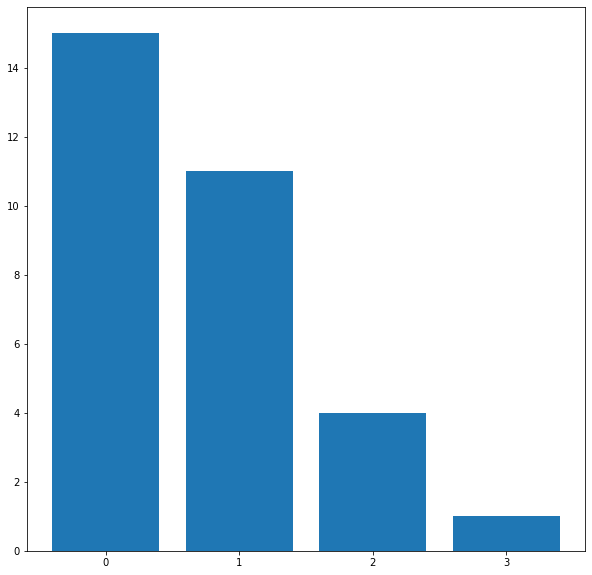

In [87]:
LA_obs = find_arrival_distribution(start_time_obj, end_time_obj, LA_arrival_info)

Poisson? True , P-value= 0.9296086588654712
Poisson(lambda = 0.709677)


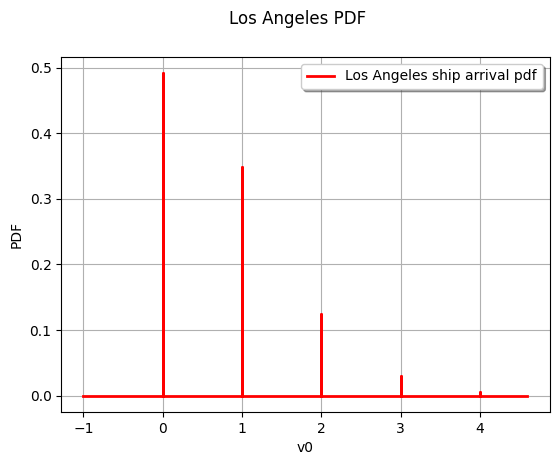

In [88]:
LA_dist = test_fitness(LA_obs)
graph = LA_dist.drawPDF()
graph.setLegends(['Los Angeles ship arrival pdf'])
graph.setTitle('Los Angeles PDF')
view = View(graph, pixelsize=(640,480))
view.show()
# view.save('Los Angeles PDF.png', dpi=100)

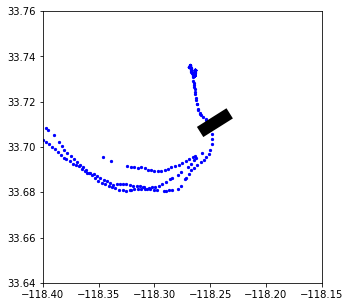

In [89]:
fig_test, ax_test = plt.subplots(1,1)
test_df = LA_df.loc[(LA_df['MMSI']==367395280)].sort_values('BaseDateTime').reset_index()
# test_df
ax_test.scatter(test_df.LON, test_df.LAT, color='b', s=5, alpha=1)
ax_test.plot(
    [gateline_dict['Los_Angeles']['start']['LON'], gateline_dict['Los_Angeles']['end']['LON']], 
    [gateline_dict['Los_Angeles']['start']['LAT'], gateline_dict['Los_Angeles']['end']['LAT']], 
    color='k', 
    linewidth=12
    )
ax_test.set_xlim(-118.4, -118.15)
ax_test.set_ylim(33.64, 33.76)
plt.show()

## 2. Long Beach Port

### 2-1. Get data

In [90]:
# Center Coordinate
port_name = 'Long_Beach'
lat_LB = 33.77
lon_LB = -118.221666666667


# anghorage info
# https://www.law.cornell.edu/cfr/text/33/110.214

In [91]:
# ship information within rectangular bound
LB_df, LB_unique_ship_df = extract_df(date_interest, 
                                      cargo_type, 
                                      lon_LB - 0.15, 
                                      lon_LB + 0.15, 
                                      lat_LB + 0.1, 
                                      lat_LB - 0.1)

### 2-2. plot entire data

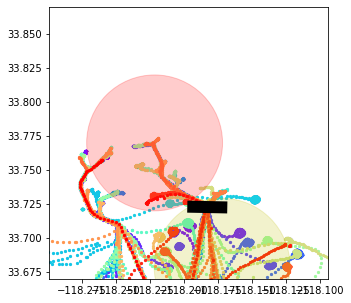

In [92]:
# plot harbor
plot_port_traffic('Long_Beach', 
                  lat_LB, 
                  lon_LB, 
                  radius=0.05, 
                  d_left=0.05, 
                  d_right=0.1, 
                  d_up=0.1, 
                  d_down=0.1, 
                  date_df=LB_df, 
                  unique_ship_df=LB_unique_ship_df, 
                  anchorage = anchorage_Los_Angeles )

### 2-3. Arrival by passing gate line

211331640 2021-01-11T09:06:34 2021-01-11T09:14:37
538007801 2021-01-06T03:07:03 2021-01-06T03:15:13
538007617 2021-01-01T02:00:06 2021-01-01T21:42:09
565963000 2021-01-02T17:13:21 2021-01-02T17:30:45
538007581 2021-01-03T00:26:53 2021-01-03T00:45:38
240801000 2021-01-03T12:15:05 2021-01-03T12:41:15
636091959 2021-01-04T15:11:19 2021-01-04T15:28:50
353243000 2021-01-05T03:49:35 2021-01-05T04:09:17
367641230 2021-01-05T12:57:47 2021-01-05T13:16:24
636018471 2021-01-10T22:27:48 2021-01-10T22:39:08
229598000 2021-01-14T14:07:59 2021-01-14T14:22:09
432664000 2021-01-08T10:42:24 2021-01-08T11:16:15
352361000 2021-01-08T18:03:37 2021-01-08T18:21:38
477607700 2021-01-10T13:25:25 2021-01-10T13:43:28
431205000 2021-01-11T07:35:25 2021-01-11T07:57:18
538008552 2021-01-12T00:01:15 2021-01-12T00:28:32
310764000 2021-01-12T02:30:05 2021-01-12T02:52:51
564548000 2021-01-13T16:56:27 2021-01-13T17:18:56
373828000 2021-01-13T17:00:00 2021-01-13T17:11:35
355368000 2021-01-15T09:39:51 2021-01-15T15:29:48


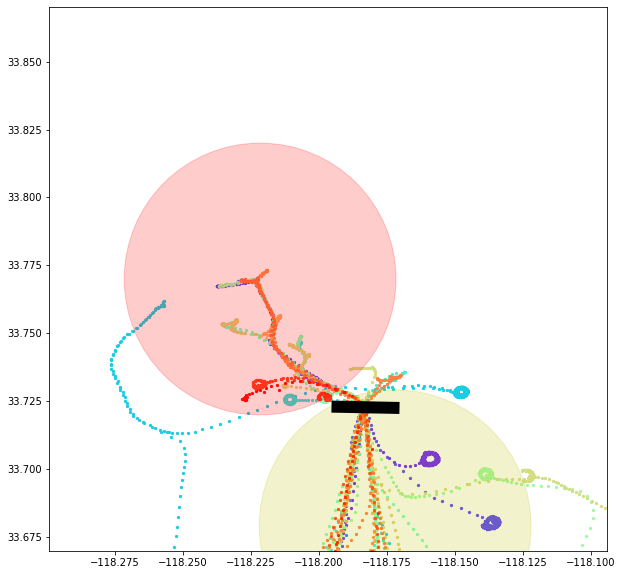

In [93]:
extract_passing_gate_line('Long_Beach', 
                          gateline_dict,
                          lat_LB, 
                          lon_LB,
                          radius=0.05, 
                          d_left=0.05, 
                          d_right=0.1, 
                          d_up=0.1, 
                          d_down=0.1, 
                          date_df=LB_df, 
                          unique_ship_df=LB_unique_ship_df, 
                          anchorage = anchorage_Los_Angeles, 
                          interest='arrival')

### 2-4 Arrival at anchorage

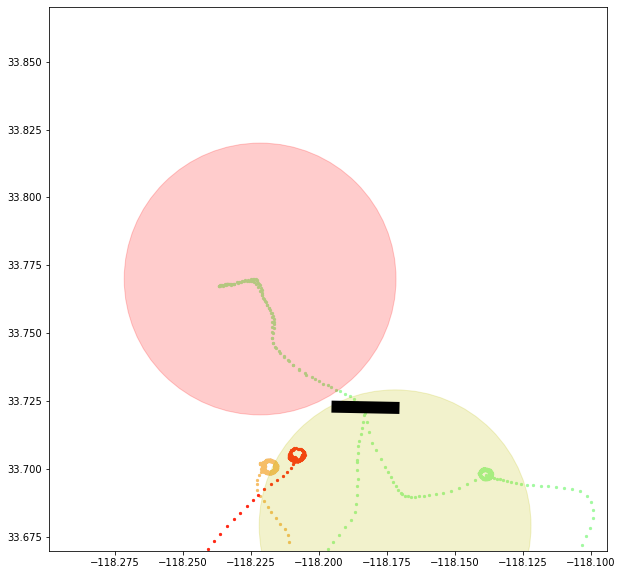

In [94]:
extract_arrival_anchorage('Long_Beach', 
                          lat_LB, 
                          lon_LB, 
                          radius=0.05, 
                          d_left=0.05, 
                          d_right=0.1, 
                          d_up=0.1, 
                          d_down=0.1, 
                          date_df=LB_df, 
                          unique_ship_df=LB_unique_ship_df, 
                          anchorage = anchorage_Los_Angeles)

### 2-5. Arrival information by processing numerical data
* There are some errors in departure passing time that could result from (1) noise of AIS sensor, (2) ship actually went out and came back such that the time order is not always departure is not later than arrival. 

In [95]:
LB_arrival_info = extract_arrival_info('Long_Beach', 
                     gateline_dict, 
                     date_df=LB_df, 
                     unique_ship_df=LB_unique_ship_df, 
                     anchorage=anchorage_Los_Angeles)

In [96]:
LB_arrival_info

,index,MMSI,anchor_start_time,anchor_last_time,arrival_passing_time,departure_passing_time
0,2,211331640,NaN,NaN,2021-01-11T09:14:37,2021-01-12T02:19:20
1,5,538007801,NaN,NaN,2021-01-06T03:15:13,2021-01-09T14:50:53
2,9,357880000,NaN,NaN,NaN,2021-01-01T01:08:54
3,10,538007617,NaN,NaN,2021-01-01T21:42:09,2021-01-01T02:00:06
4,16,477738600,NaN,NaN,NaN,2021-01-06T00:41:28
5,18,565963000,NaN,NaN,2021-01-02T17:30:45,NaN
6,21,538007581,NaN,NaN,2021-01-03T00:45:38,2021-01-09T03:59:04
7,22,370157000,NaN,NaN,NaN,2021-01-03T01:38:25
8,23,240801000,NaN,NaN,2021-01-03T12:41:15,2021-01-04T01:46:11
9,27,565747000,NaN,NaN,NaN,2021-01-04T14:19:13


In [97]:
LB_unique_ship_df.to_csv("/content/drive/My Drive/Database/ENGS103/USA/2021/longbeach_arrival_ships.csv")  

In [98]:
files.download("/content/drive/My Drive/Database/ENGS103/USA/2021/longbeach_arrival_ships.csv")  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 2-6. Analysis of arrival ships data (Poisson distribution fit)

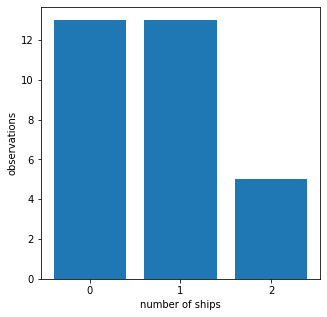

In [175]:
LB_obs = find_arrival_distribution(start_time_obj, end_time_obj, LB_arrival_info)

Poisson? True , P-value= 0.7376600446182517
Poisson(lambda = 0.741935)


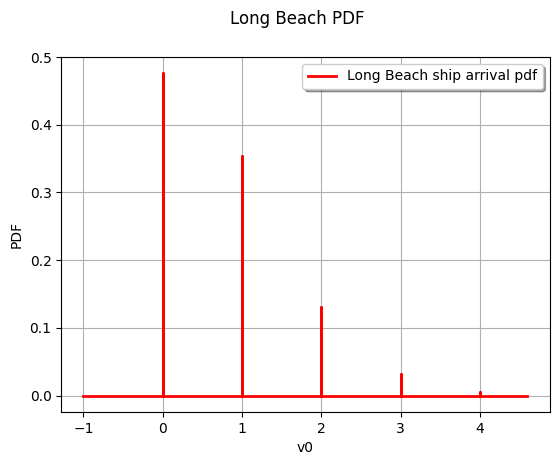

In [100]:
LB_dist = test_fitness(LB_obs)
graph = LB_dist.drawPDF()
graph.setLegends(['Long Beach ship arrival pdf'])
graph.setTitle('Long Beach PDF')
view = View(graph, pixelsize=(640,480))
view.show()

## 3. Seattle/Tacoma Port

### 3-1. Get data

In [101]:
# Center Coordinate
port_name = 'Seattle'
lat_SA = 47.4
lon_SA = -122.366666666667

anchorage_Seattle = {
    'SA': {'LAT': lat_SA +0.05, 'LON': lon_SA -0.5, 'radius': 0.05},
}

# anghorage info
# https://www.law.cornell.edu/cfr/text/33/110.214

In [102]:
# ship information within rectangular bound
SA_df, SA_unique_ship_df = extract_df(date_interest, 
                                      cargo_type, 
                                      lon_SA - 2.0, 
                                      lon_SA + 0.5, 
                                      lat_SA + 1.0, 
                                      lat_SA - 0.5)

In [103]:
SA_unique_ship_df

,index,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
0,11062,311008600,2021-01-01T00:17:14,47.41777,-122.37355,17.4,330.5,333.0,VIOLET ACE,IMO9395630,C6XG3,70.0,0.0,189.0,32.0,9.1,70.0,A
1,17355,563102400,2021-01-01T00:17:17,48.35433,-124.15150,21.8,291.0,292.0,BER SALUTE,IMO9300477,9V2791,74.0,0.0,300.0,43.0,-12.1,74.0,A
2,23186,565193000,2021-01-01T00:18:59,47.29073,-122.42215,0.2,299.9,178.0,ATLANTIC ENSENADA,IMO9324071,S6FM9,70.0,1.0,189.0,32.0,12.5,70.0,A
3,61597,636092920,2021-01-01T00:31:09,47.53672,-122.51515,0.2,148.7,182.0,RDO CONCERT,IMO9415844,A8TH7,74.0,1.0,304.0,40.0,12.3,74.0,A
4,158671,367105730,2021-01-01T00:52:51,47.63284,-122.33956,102.3,360.0,511.0,SANCTUARY,NaN,WDC9706,37.0,0.0,21.0,6.0,NaN,97.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,1752283,371976000,2021-01-15T07:00:07,48.35782,-124.36498,10.9,116.0,115.0,GLORY AMSTERDAM,IMO9287182,3EEZ7,70.0,0.0,225.0,32.0,14.2,70.0,A
69,3140238,477222600,2021-01-15T12:31:24,48.35646,-124.34976,9.2,112.8,112.0,OOCL MEMPHIS,IMO9486075,VRLQ3,70.0,0.0,334.0,42.0,14.7,70.0,A
70,3537949,477825000,2021-01-15T14:00:05,48.36247,-124.35637,9.2,116.8,119.0,OOCL CHICAGO,IMO9199270,VRWQ2,70.0,0.0,277.0,40.0,14.0,71.0,A
71,5205138,218522000,2021-01-15T20:23:03,48.36015,-124.35656,13.2,114.4,114.0,MARIA,IMO9266566,DPWD,79.0,0.0,151.0,22.0,7.6,79.0,A


### 3-2. plot entire data

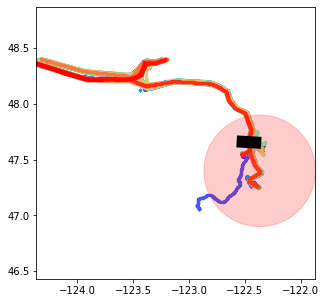

In [104]:
# plot harbor
plot_port_traffic('Seattle', 
                  lat_SA, 
                  lon_SA, 
                  radius=0.5, 
                  d_left=2.0, 
                  d_right=0.5, 
                  d_up=1.0, 
                  d_down=0.5, 
                  date_df=SA_df, 
                  unique_ship_df=SA_unique_ship_df)

### 2-3. Arrival by passing gate line

310968322 2021-01-01T13:00:06 2021-01-01T14:15:54
477938500 2021-01-10T23:32:57 2021-01-11T00:32:38
538009060 2021-01-02T16:27:15 2021-01-02T17:32:59
249949000 2021-01-03T06:55:13 2021-01-03T08:14:44
636015131 2021-01-03T22:42:25 2021-01-03T23:49:55
372829000 2021-01-04T12:23:11 2021-01-04T13:16:28
218824714 2021-01-04T20:28:15 2021-01-04T21:26:09
538007481 2021-01-15T03:41:12 2021-01-15T04:39:37
636018069 2021-01-05T13:54:19 2021-01-05T14:57:52
636013698 2021-01-06T09:51:28 2021-01-06T10:55:27
369285000 2021-01-06T22:14:14 2021-01-06T23:02:15
215558000 2021-01-06T23:47:37 2021-01-07T00:48:02
372740000 2021-01-10T17:54:35 2021-01-10T18:46:54
357547000 2021-01-07T19:28:30 2021-01-07T20:28:30
636015773 2021-01-07T20:00:00 2021-01-07T21:14:09
353006000 2021-01-08T15:01:18 2021-01-08T16:50:20
355433000 2021-01-08T21:37:18 2021-01-08T22:47:07
636019081 2021-01-09T23:03:16 2021-01-09T23:57:58
371798000 2021-01-10T22:44:30 2021-01-10T23:47:42
374366000 2021-01-11T02:48:17 2021-01-11T04:03:36


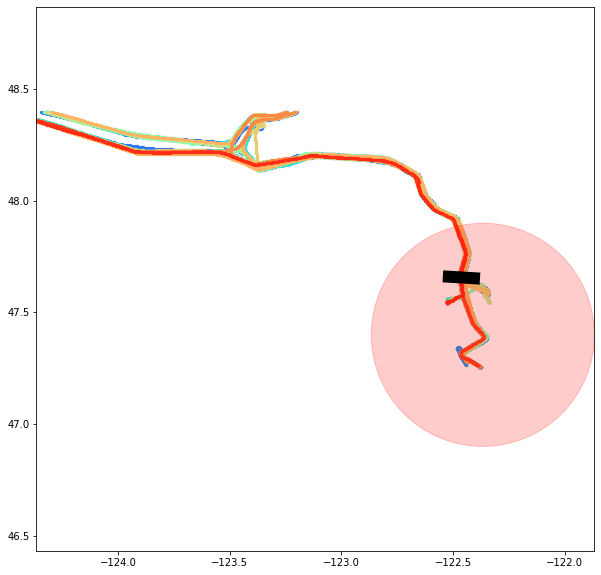

In [105]:
extract_passing_gate_line('Seattle', 
                          gateline_dict,
                          lat_SA, 
                          lon_SA, 
                          radius=0.5, 
                          d_left=2.0, 
                          d_right=0.5, 
                          d_up=1.0, 
                          d_down=0.5, 
                          date_df=SA_df, 
                          unique_ship_df=SA_unique_ship_df, 
                          # anchorage = anchorage_Los_Angeles, 
                          interest='arrival')

### 3-4. Arrival information by processing numerical data

In [106]:
SA_arrival_info = extract_arrival_info('Seattle', 
                     gateline_dict, 
                     date_df=SA_df, 
                     unique_ship_df=SA_unique_ship_df)
                    #  anchorage=anchorage_Los_Angeles)

In [107]:
SA_arrival_info

,index,MMSI,anchor_start_time,anchor_last_time,arrival_passing_time,departure_passing_time
0,0,311008600,NaN,NaN,NaN,2021-01-01T01:05:30
1,2,565193000,NaN,NaN,NaN,2021-01-09T14:26:53
2,3,636092920,NaN,NaN,NaN,2021-01-11T14:08:43
3,6,477961600,NaN,NaN,NaN,2021-01-03T02:51:24
4,7,310968322,NaN,NaN,2021-01-01T14:15:54,2021-01-13T21:15:05
5,8,373889000,NaN,NaN,NaN,2021-01-03T05:43:19
6,11,477938500,NaN,NaN,2021-01-11T00:32:38,2021-01-15T02:18:05
7,12,538009060,NaN,NaN,2021-01-02T17:32:59,2021-01-04T15:07:47
8,14,249949000,NaN,NaN,2021-01-03T08:14:44,NaN
9,17,636015131,NaN,NaN,2021-01-03T23:49:55,2021-01-04T14:08:42


### 3-6. Analysis of arrival ships data (Poisson distribution fit)

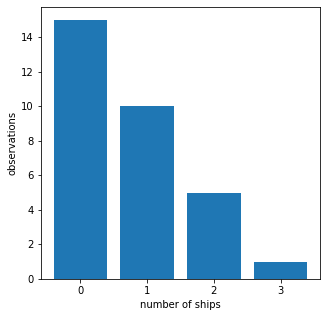

In [176]:
SA_obs = find_arrival_distribution(start_time_obj, end_time_obj, SA_arrival_info, anchor_contain=False)

Poisson? True , P-value= 0.9124712592378256
Poisson(lambda = 0.741935)


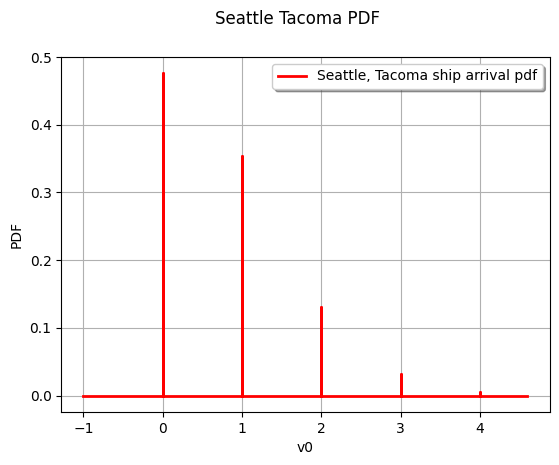

In [109]:
SA_dist = test_fitness(SA_obs)
graph = SA_dist.drawPDF()
graph.setLegends(['Seattle, Tacoma ship arrival pdf'])
graph.setTitle('Seattle Tacoma PDF')
view = View(graph, pixelsize=(640,480))
view.show()

## 4. San Francisco / Oakland Port

### 4-1. Get data

In [110]:
# Center Coordinate
port_name = 'San_Francisco'
lat_SF = 37.77493
lon_SF = -122.41942

anchorage_SF = {
    'SF': {'LAT': lat_SF +0.05, 'LON': lon_SF -0.5, 'radius': 0.05},
}

# anghorage info
# https://www.law.cornell.edu/cfr/text/33/110.214

In [111]:
# ship information within rectangular bound
SF_df, SF_unique_ship_df = extract_df(date_interest, 
                                      cargo_type, 
                                      lon_SF - 0.5, 
                                      lon_SF + 0.5, 
                                      lat_SF + 0.5, 
                                      lat_SF - 0.5)

In [112]:
SF_unique_ship_df

,index,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
0,4658,372104000,2021-01-01T00:01:56,37.75764,-122.68514,9.0,286.5,290.0,HANNOVER BRIDGE,IMO9302138,3EIC8,70.0,0.0,336.0,45.0,14.0,71.0,A
1,16916,366879000,2021-01-01T00:18:30,37.80881,-122.40681,0.2,57.5,511.0,JEREMIAH O'BRIEN,IMO5171749,KXCH,70.0,5.0,134.0,17.0,NaN,73.0,A
2,353356,309822000,2021-01-01T01:45:56,37.51395,-122.20910,0.2,153.0,229.0,HON HENRY JACKMAN,IMO7926174,C6VQ9,70.0,5.0,244.0,32.0,12.8,70.0,A
3,745619,373701000,2021-01-01T03:28:46,37.74011,-122.32943,0.2,110.1,194.0,BASIC BRAVE,IMO9473690,3EVG4,70.0,1.0,179.0,28.0,10.1,79.0,A
4,813477,373471000,2021-01-01T03:46:28,37.74945,-122.33237,0.2,122.7,217.0,MIMITSU,IMO9527958,3ETU4,70.0,1.0,184.0,30.0,10.0,70.0,A
5,2598437,636018222,2021-01-01T11:18:19,37.83637,-122.91698,10.0,116.6,119.0,NYK DELPHINUS,IMO9337652,D5OS3,70.0,0.0,294.0,32.0,9.2,70.0,A
6,4433134,636015094,2021-01-01T18:54:37,37.82363,-122.89477,12.3,120.0,121.0,NAVIOS SERENITY,IMO9498432,A8YO6,70.0,0.0,180.0,30.0,9.9,70.0,A
7,5124693,416482000,2021-01-01T21:36:46,37.80805,-122.33892,0.2,189.7,236.0,EVER LOGIC,IMO9604081,BKIF,70.0,5.0,334.0,45.0,14.2,74.0,A
8,5548991,636015676,2021-01-01T23:15:32,38.04742,-121.93047,10.0,282.6,293.0,BELLAMYS,IMO9286956,D5CE4,70.0,0.0,225.0,32.0,14.0,70.0,A
9,3331295,477427600,2021-01-02T13:41:42,37.83645,-122.91711,6.7,120.1,123.0,JAMES BAY,IMO9610676,VRLU4,70.0,0.0,179.0,30.0,10.5,70.0,A


### 4-2. plot entire data

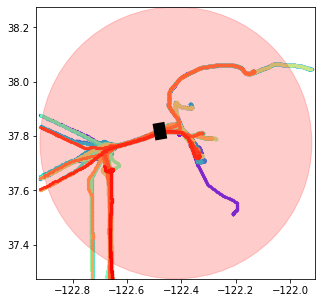

In [113]:
# plot harbor
plot_port_traffic('San_Francisco', 
                  lat_SF, 
                  lon_SF, 
                  radius=0.5, 
                  d_left=0.5, 
                  d_right=0.5, 
                  d_up=0.5, 
                  d_down=0.5, 
                  date_df=SF_df, 
                  unique_ship_df=SF_unique_ship_df)

### 4-3. Arrival by passing gate line

309822000 2021-01-03T17:57:19 2021-01-03T18:28:39
373701000 2021-01-03T16:19:25 2021-01-11T16:02:25
373471000 2021-01-07T04:47:04 2021-01-07T05:10:10
636018222 2021-01-01T13:18:42 2021-01-03T14:17:15
416482000 2021-01-03T10:49:56 2021-01-03T11:17:18
636015676 2021-01-02T02:20:34 2021-01-08T16:07:50
636015182 2021-01-03T00:58:32 2021-01-03T01:58:45
257310000 2021-01-04T02:13:55 2021-01-04T02:16:07
352718000 2021-01-04T07:50:59 2021-01-06T04:21:32
565747000 2021-01-06T01:25:36 2021-01-13T04:39:23
563061300 2021-01-07T00:21:32 2021-01-09T03:18:14
563433000 2021-01-07T03:34:27 2021-01-09T01:02:13
235098885 2021-01-07T12:48:51 2021-01-09T03:58:11
235098383 2021-01-09T01:47:46 2021-01-11T07:56:10
367375930 2021-01-09T22:46:08 2021-01-09T23:17:07
311008700 2021-01-11T03:43:29 2021-01-12T00:19:11
357694000 2021-01-13T06:47:07 2021-01-14T01:40:45
431205000 2021-01-14T09:56:57 2021-01-15T10:18:22
count 18


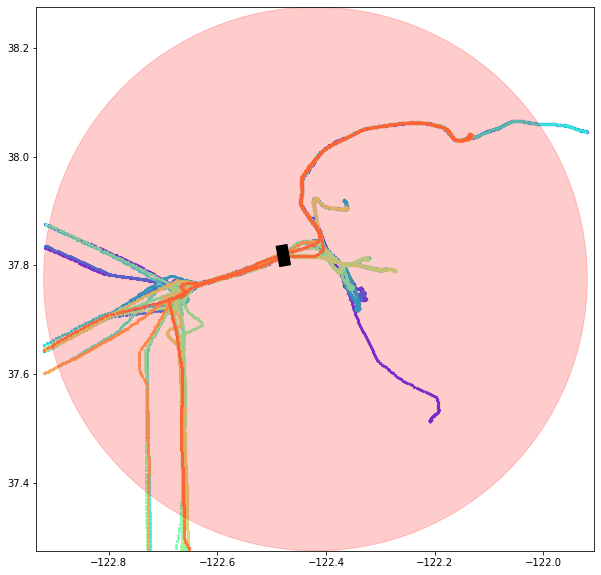

In [114]:
extract_passing_gate_line('San_Francisco', 
                          gateline_dict,
                          lat_SF, 
                          lon_SF, 
                          radius=0.5, 
                          d_left=0.5, 
                          d_right=0.5, 
                          d_up=0.5, 
                          d_down=0.5, 
                          date_df=SF_df, 
                          unique_ship_df=SF_unique_ship_df, 
                          # anchorage = anchorage_Los_Angeles, 
                          interest='arrival')

### 4-4. Arrival information by processing numerical data

In [115]:
SF_arrival_info = extract_arrival_info('San_Francisco', 
                     gateline_dict, 
                     date_df=SF_df, 
                     unique_ship_df=SF_unique_ship_df)
                    #  anchorage=anchorage_Los_Angeles)

In [116]:
SF_arrival_info

,index,MMSI,anchor_start_time,anchor_last_time,arrival_passing_time,departure_passing_time
0,2,309822000,NaN,NaN,2021-01-03T18:28:39,2021-01-12T08:06:48
1,3,373701000,NaN,NaN,2021-01-11T16:02:25,NaN
2,4,373471000,NaN,NaN,2021-01-07T05:10:10,NaN
3,5,636018222,NaN,NaN,2021-01-03T14:17:15,2021-01-01T13:18:42
4,6,636015094,NaN,NaN,NaN,2021-01-01T20:47:47
5,7,416482000,NaN,NaN,2021-01-03T11:17:18,NaN
6,8,636015676,NaN,NaN,2021-01-08T16:07:50,NaN
7,9,477427600,NaN,NaN,NaN,2021-01-02T17:11:01
8,10,636015182,NaN,NaN,2021-01-03T01:58:45,NaN
9,11,257310000,NaN,NaN,2021-01-04T02:16:07,NaN


### 4-6. Analysis of arrival ships data (Poisson distribution fit)

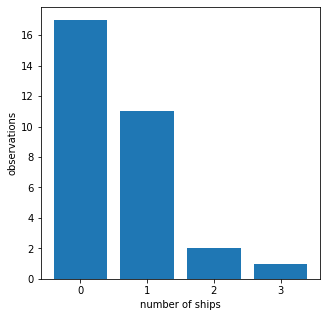

In [177]:
SF_obs = find_arrival_distribution(start_time_obj, end_time_obj, SF_arrival_info, anchor_contain=False)

Poisson? True , P-value= 0.9004818658705617
Poisson(lambda = 0.580645)


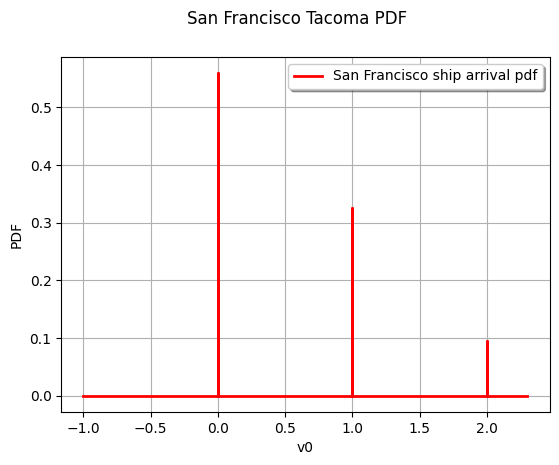

In [118]:
SF_dist = test_fitness(SF_obs)
graph = SF_dist.drawPDF()
graph.setLegends(['San Francisco ship arrival pdf'])
graph.setTitle('San Francisco Tacoma PDF')
view = View(graph, pixelsize=(640,480))
view.show()

# Different Year Comparison
## 5. Port of Los Angeles (2019)

### 5-1. Get data

In [119]:
year = '2019'
date_interest = []
for i in range(1, 16):
  date = str(i)
  if len(date) !=2:
    date = '0' + date
  date_interest.append('{}_01_{}'.format(year,date))

# date_intrest = ['2021_01_01', '2021_01_02', '2021_01_03', '2021_01_04', '2021_01_05', '2021_01_06', '2021_01_07',]
cargo_type = [70,71,72,73,74,75,76,77,78,79,90,91,92,93,94,95,96,97,98,99]

In [120]:
date_interest

['2019_01_01',
 '2019_01_02',
 '2019_01_03',
 '2019_01_04',
 '2019_01_05',
 '2019_01_06',
 '2019_01_07',
 '2019_01_08',
 '2019_01_09',
 '2019_01_10',
 '2019_01_11',
 '2019_01_12',
 '2019_01_13',
 '2019_01_14',
 '2019_01_15']

In [121]:
# Center Coordinate
port_name = 'Los_Angeles'
lat_Los_Angeles = 33.7292
lon_Los_Angeles = -118.2620

anchorage_Los_Angeles = {
    'B-7': {'LAT': lat_Los_Angeles-0.05, 'LON': lon_Los_Angeles + 0.09, 'radius': 0.05},
}

# anghorage info
# https://www.law.cornell.edu/cfr/text/33/110.214

In [122]:
# ship information within rectangular bound
LA_df_2019, LA_unique_ship_df_2019 = extract_df(date_interest, 
                                      cargo_type, 
                                      lon_Los_Angeles - 0.15, 
                                      lon_Los_Angeles + 0.15, 
                                      lat_Los_Angeles + 0.1, 
                                      lat_Los_Angeles - 0.1)

In [123]:
LA_unique_ship_df_2019

,index,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,2648,367492920,2019-01-01T00:00:07,33.73457,-118.27083,2.8,52.2,511.0,KENNETH CARL,IMO8978710,WDF8246,90.0,0.0,33.0,7.0,2.7,79.0,A
1,4073,338454000,2019-01-01T00:00:10,33.64605,-118.34792,9.6,240.1,241.0,BERTO L MILLER,IMO8964850,WDG6273,90.0,0.0,49.0,13.0,3.1,70.0,A
2,4249,636018572,2019-01-01T00:00:09,33.75107,-118.22964,5.3,96.2,100.0,MSC ELISA,IMO9463059,D5QH7,74.0,0.0,366.0,48.0,11.0,74.0,A
3,17643,355139000,2019-01-01T00:03:11,33.73822,-118.21737,0.2,106.0,219.0,MERMAID ACE,IMO9561289,3FCG3,70.0,1.0,199.0,32.0,9.8,79.0,A
4,17818,211311970,2019-01-01T00:03:06,33.70004,-118.15196,0.2,320.0,230.0,DALLAS EXPRESS,IMO9193288,DGAF,70.0,1.0,293.0,32.0,13.6,79.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,3146944,636015182,2019-01-15T11:37:47,33.63186,-118.26804,8.4,24.3,27.0,YM MILESTONE,IMO9484998,A8ZC9,70.0,0.0,305.0,40.0,12.0,71.0,A
82,5370550,565661000,2019-01-15T19:20:10,33.63271,-118.40594,11.3,123.1,122.0,MAERSK ANTARES,IMO9342504,9VHK7,70.0,0.0,337.0,45.0,15.0,71.0,A
83,5632727,371886000,2019-01-15T20:15:08,33.63508,-118.41176,9.5,122.6,123.0,BASIC RAINBOW,IMO9604847,3FIZ2,70.0,0.0,183.0,29.0,10.4,70.0,A
84,6088891,235102677,2019-01-15T21:57:54,33.63158,-118.16928,6.9,23.4,28.0,EVER LENIENT,IMO9604146,2HDF9,70.0,0.0,334.0,45.0,14.2,70.0,A


### 5-2. plot entire data

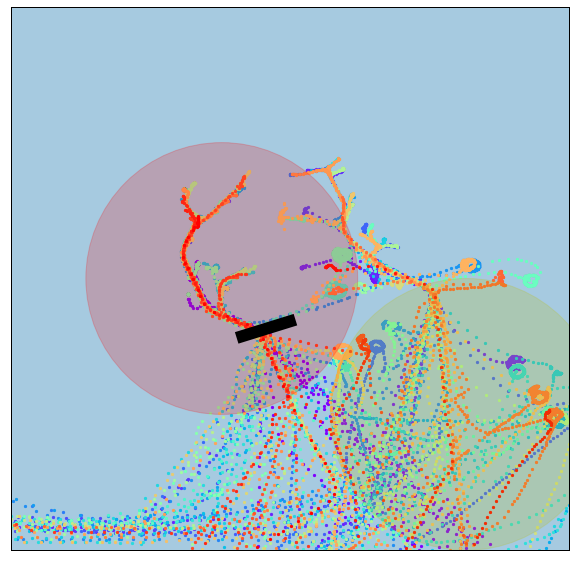

In [179]:
# plot harbor
plot_port_traffic('Los_Angeles', 
                  lat_Los_Angeles, 
                  lon_Los_Angeles, 
                  radius=0.05, 
                  d_left=0.05, 
                  d_right=0.1, 
                  d_up=0.1, 
                  d_down=0.1, 
                  date_df=LA_df_2019, 
                  unique_ship_df=LA_unique_ship_df_2019, 
                  anchorage = anchorage_Los_Angeles )

### 5-3. Arrival by passing gate line

367492920 2019-01-02T17:22:34 2019-01-02T23:07:24
338454000 2019-01-05T13:30:18 2019-01-05T13:59:41
566974000 2019-01-02T02:54:03 2019-01-04T13:22:00
372945000 2019-01-02T07:20:59 2019-01-02T07:57:39
235335000 2019-01-04T05:06:12 2019-01-04T05:11:02
218846000 2019-01-06T00:21:23 2019-01-06T01:03:33
565807000 2019-01-05T12:52:17 2019-01-05T12:57:47
372955000 2019-01-03T03:55:43 2019-01-13T08:11:11
367035570 2019-01-03T08:46:12 2019-01-03T08:53:22
636017154 2019-01-04T14:20:00 2019-01-04T14:27:19
235102678 2019-01-05T14:10:51 2019-01-05T14:19:44
220379000 2019-01-06T02:16:26 2019-01-06T02:27:36
372319000 2019-01-06T13:37:53 2019-01-06T13:42:42
563758000 2019-01-04T13:01:10 2019-01-04T13:08:21
636018189 2019-01-06T13:15:05 2019-01-06T13:22:14
372724000 2019-01-05T22:58:49 2019-01-05T23:07:29
477220600 2019-01-06T11:57:58 2019-01-06T12:08:28
235069415 2019-01-08T13:15:41 2019-01-08T13:20:51
367533290 2019-01-06T15:10:41 2019-01-06T15:38:00
367395280 2019-01-06T18:27:39 2019-01-06T19:30:37


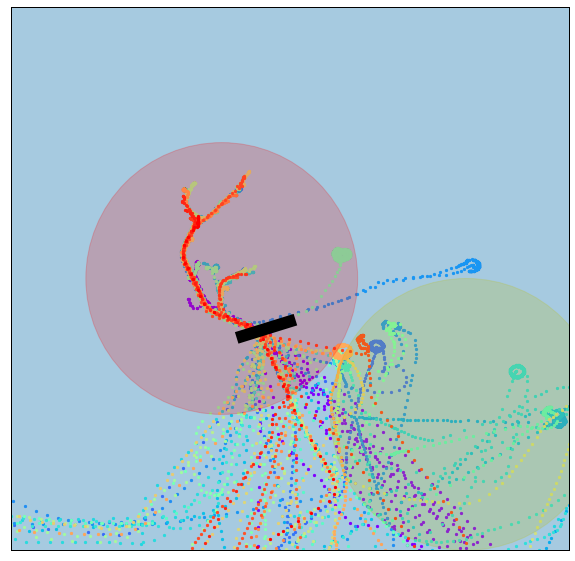

In [142]:
extract_passing_gate_line('Los_Angeles', 
                          gateline_dict,
                          lat_Los_Angeles, 
                          lon_Los_Angeles, 
                          radius=0.05, 
                          d_left=0.05, 
                          d_right=0.1, 
                          d_up=0.1, 
                          d_down=0.1, 
                          date_df=LA_df_2019, 
                          unique_ship_df=LA_unique_ship_df_2019, 
                          anchorage = anchorage_Los_Angeles, 
                          interest='arrival')

### 5-4 Arrival at anchorage

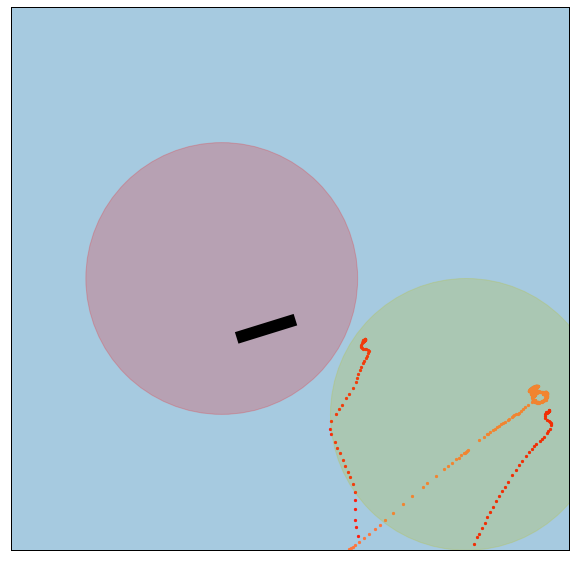

In [143]:
extract_arrival_anchorage('Los_Angeles', 
                          lat_Los_Angeles, 
                          lon_Los_Angeles, 
                          radius=0.05, 
                          d_left=0.05, 
                          d_right=0.1, 
                          d_up=0.1, 
                          d_down=0.1, 
                          date_df=LA_df_2019, 
                          unique_ship_df=LA_unique_ship_df_2019, 
                          anchorage = anchorage_Los_Angeles )

### 5-5. Arrival information by processing numerical data
* There are some errors in departure passing time that could result from (1) noise of AIS sensor, (2) ship actually went out and came back such that the time order is not always departure is not later than arrival. 

In [181]:
# time setting
start_time = '2019-01-01T00:00:00'
end_time = '2019-01-16T00:00:00'
# end_time = '2021-01-08T00:00:00'
time_increment = timedelta(hours=12)

start_time_obj = datetime.strptime(start_time, '%Y-%m-%d{}%H:%M:%S'.format("T")) # str to obj
end_time_obj = datetime.strptime(end_time, '%Y-%m-%d{}%H:%M:%S'.format("T")) 
start_time_str = start_time_obj.strftime('%Y-%m-%d{}%H:%M:%S'.format("T")) # obj to str
end_time_str = (start_time_obj + time_increment).strftime('%Y-%m-%d{}%H:%M:%S'.format("T"))

In [132]:
LA_arrival_info_2019 = extract_arrival_info('Los_Angeles', 
                     gateline_dict, 
                     date_df=LA_df_2019, 
                     unique_ship_df=LA_unique_ship_df_2019, 
                     anchorage=anchorage_Los_Angeles)

In [136]:
LA_arrival_info_2019

,index,MMSI,anchor_start_time,anchor_last_time,arrival_passing_time,departure_passing_time
0,0,367492920,NaN,NaN,2019-01-02T23:07:24,2019-01-02T17:22:34
1,1,338454000,NaN,NaN,2019-01-05T13:59:41,NaN
2,6,416475000,NaN,NaN,NaN,2019-01-04T13:10:50
3,7,370959000,NaN,NaN,NaN,2019-01-04T02:46:09
4,9,235093569,NaN,NaN,NaN,2019-01-04T03:39:24
5,12,566974000,NaN,NaN,2019-01-04T13:22:00,2019-01-06T00:17:20
6,13,372945000,NaN,NaN,2019-01-02T07:57:39,2019-01-03T02:48:58
7,16,235335000,NaN,NaN,2019-01-04T05:11:02,2019-01-09T12:58:56
8,17,218846000,NaN,NaN,2019-01-06T01:03:33,2019-01-13T12:20:28
9,19,372934000,NaN,NaN,NaN,2019-01-05T08:08:52


### 5-6. Analysis of arrival ships data (Poisson distribution fit)

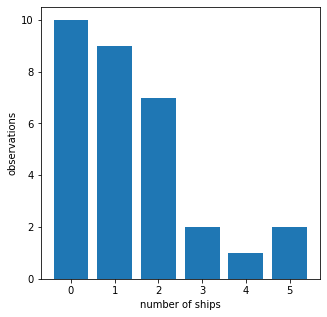

In [182]:
LA_obs = find_arrival_distribution(start_time_obj, end_time_obj, LA_arrival_info_2019)

Poisson? True , P-value= 0.809077129769525
Poisson(lambda = 1.3871)


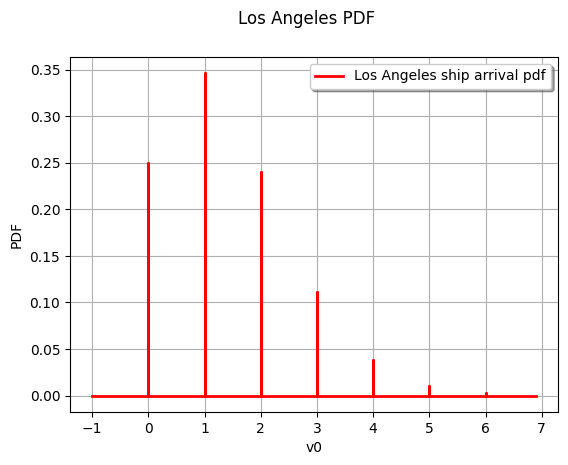

In [138]:
LA_dist = test_fitness(LA_obs)
graph = LA_dist.drawPDF()
graph.setLegends(['Los Angeles ship arrival pdf'])
graph.setTitle('Los Angeles PDF')
view = View(graph, pixelsize=(640,480))
view.show()
# view.save('Los Angeles PDF.png', dpi=100)

# Different Year Comparison
## 6. Port of Los Angeles (2020)

### 6-1. Get data

In [158]:
year = '2020'
date_interest = []
for i in range(1, 16):
  date = str(i)
  if len(date) !=2:
    date = '0' + date
  date_interest.append('{}_01_{}'.format(year,date))

# date_intrest = ['2021_01_01', '2021_01_02', '2021_01_03', '2021_01_04', '2021_01_05', '2021_01_06', '2021_01_07',]
cargo_type = [70,71,72,73,74,75,76,77,78,79,90,91,92,93,94,95,96,97,98,99]

In [159]:
date_interest

['2020_01_01',
 '2020_01_02',
 '2020_01_03',
 '2020_01_04',
 '2020_01_05',
 '2020_01_06',
 '2020_01_07',
 '2020_01_08',
 '2020_01_09',
 '2020_01_10',
 '2020_01_11',
 '2020_01_12',
 '2020_01_13',
 '2020_01_14',
 '2020_01_15']

In [160]:
# Center Coordinate
port_name = 'Los_Angeles'
lat_Los_Angeles = 33.7292
lon_Los_Angeles = -118.2620

anchorage_Los_Angeles = {
    'B-7': {'LAT': lat_Los_Angeles-0.05, 'LON': lon_Los_Angeles + 0.09, 'radius': 0.05},
}

# anghorage info
# https://www.law.cornell.edu/cfr/text/33/110.214

In [161]:
# ship information within rectangular bound
LA_df_2020, LA_unique_ship_df_2020 = extract_df(date_interest, 
                                      cargo_type, 
                                      lon_Los_Angeles - 0.15, 
                                      lon_Los_Angeles + 0.15, 
                                      lat_Los_Angeles + 0.1, 
                                      lat_Los_Angeles - 0.1)

In [162]:
LA_unique_ship_df_2020

,index,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,49515,636013644,2020-01-01T00:09:44,33.69618,-118.12438,0.3,240.6,241.0,DEVA,IMO9278105,A8OK3,70.0,1.0,259.0,32.0,12.6,71.0,A
1,213457,477177400,2020-01-01T00:52:46,33.74679,-118.20681,0.2,278.3,179.0,DARLING RIVER,IMO9378008,VRET8,70.0,5.0,179.0,28.0,10.2,70.0,A
2,322640,367641230,2020-01-01T01:15:56,33.75950,-118.27617,0.6,126.0,216.0,MARJORIE C,IMO9619684,WDH6745,70.0,0.0,210.0,32.0,9.8,70.0,A
3,349650,367533290,2020-01-01T01:22:39,33.73451,-118.27072,0.2,281.9,511.0,MARIE CHERAMIE,IMO8964862,WDG4131,90.0,0.0,49.0,13.0,3.1,70.0,A
4,787588,563033000,2020-01-01T03:11:38,33.72969,-118.25676,0.3,137.3,71.0,EVER LOVELY,IMO9629110,9V9793,70.0,5.0,334.0,45.0,14.2,71.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2810878,367035570,2020-01-15T10:44:10,33.73331,-118.26365,0.3,241.4,193.0,AMERICAN ISLANDER,NaN,WDC5089,60.0,3.0,28.0,7.0,NaN,90.0,A
65,3330488,477738500,2020-01-15T12:39:28,33.63218,-118.22567,9.5,40.0,38.0,OOCL LONDON,IMO9417268,VRGO2,70.0,0.0,322.0,42.0,14.5,71.0,A
66,4565410,366675760,2020-01-15T17:19:52,33.70472,-118.40396,9.2,136.1,511.0,ANTICIPATION,NaN,WCR4950,37.0,0.0,23.0,6.0,NaN,99.0,A
67,5933764,356046000,2020-01-15T22:16:40,33.62965,-118.16628,5.8,333.0,330.0,PENGHU SW,IMO9450155,H9FR,70.0,0.0,177.0,28.0,10.8,70.0,A


### 6-2. plot entire data

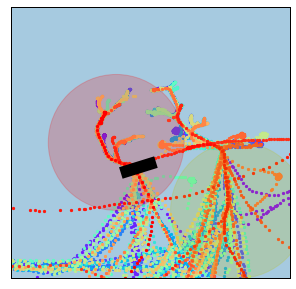

In [163]:
# plot harbor
plot_port_traffic('Los_Angeles', 
                  lat_Los_Angeles, 
                  lon_Los_Angeles, 
                  radius=0.05, 
                  d_left=0.05, 
                  d_right=0.1, 
                  d_up=0.1, 
                  d_down=0.1, 
                  date_df=LA_df_2020, 
                  unique_ship_df=LA_unique_ship_df_2020, 
                  anchorage = anchorage_Los_Angeles )

### 6-3. Arrival by passing gate line

367641230 2020-01-01T01:52:36 2020-01-14T08:36:17
367533290 2020-01-02T23:34:38 2020-01-04T23:41:58
309955000 2020-01-02T07:50:20 2020-01-02T07:58:31
563025600 2020-01-02T10:53:29 2020-01-02T10:58:50
416498000 2020-01-02T09:39:47 2020-01-02T10:17:16
441343000 2020-01-02T10:36:31 2020-01-02T10:44:21
636015370 2020-01-03T05:56:22 2020-01-03T06:02:20
636017155 2020-01-04T13:38:27 2020-01-04T14:04:27
416482000 2020-01-06T21:58:02 2020-01-10T02:43:23
369567000 2020-01-07T13:02:16 2020-01-07T13:08:06
636018223 2020-01-07T23:04:36 2020-01-07T23:10:26
357147000 2020-01-08T13:03:30 2020-01-08T13:11:33
371929000 2020-01-08T21:54:27 2020-01-08T22:03:27
372531000 2020-01-08T22:35:52 2020-01-08T23:06:12
477795300 2020-01-09T12:26:02 2020-01-09T12:35:09
235102679 2020-01-09T12:40:53 2020-01-09T13:11:12
311004900 2020-01-10T12:33:59 2020-01-10T13:06:01
636018189 2020-01-10T22:50:36 2020-01-10T23:11:37
636018560 2020-01-11T12:45:02 2020-01-11T13:20:32
636018225 2020-01-11T23:28:30 2020-01-11T23:37:40


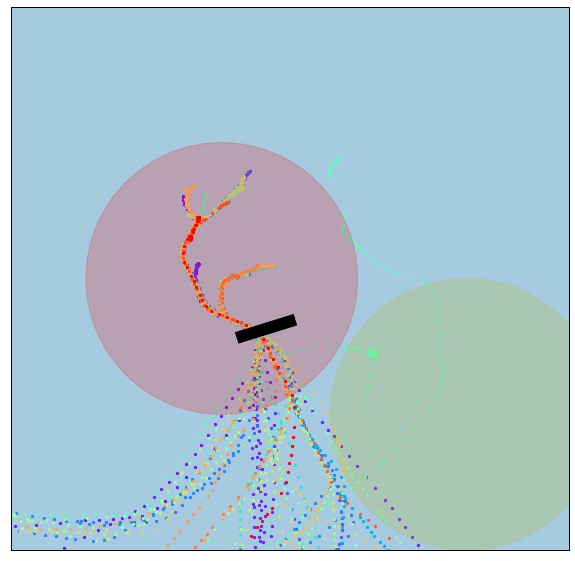

In [164]:
extract_passing_gate_line('Los_Angeles', 
                          gateline_dict,
                          lat_Los_Angeles, 
                          lon_Los_Angeles, 
                          radius=0.05, 
                          d_left=0.05, 
                          d_right=0.1, 
                          d_up=0.1, 
                          d_down=0.1, 
                          date_df=LA_df_2020, 
                          unique_ship_df=LA_unique_ship_df_2020, 
                          anchorage = anchorage_Los_Angeles, 
                          interest='arrival')

### 6-4 Arrival at anchorage

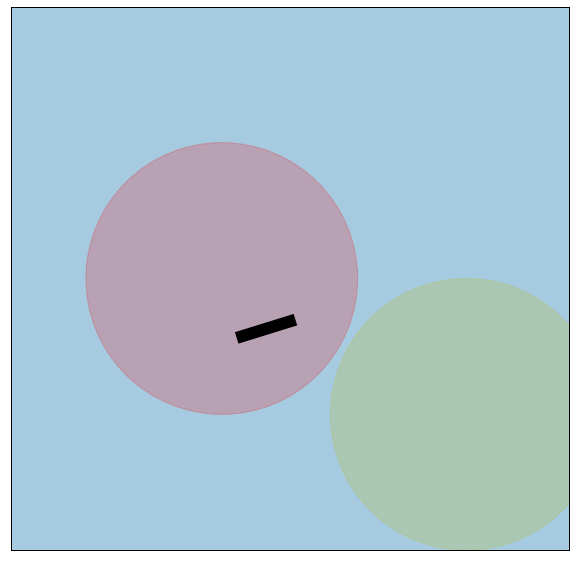

In [165]:
extract_arrival_anchorage('Los_Angeles', 
                          lat_Los_Angeles, 
                          lon_Los_Angeles, 
                          radius=0.05, 
                          d_left=0.05, 
                          d_right=0.1, 
                          d_up=0.1, 
                          d_down=0.1, 
                          date_df=LA_df_2020, 
                          unique_ship_df=LA_unique_ship_df_2020, 
                          anchorage = anchorage_Los_Angeles )

### 6-5. Arrival information by processing numerical data
* There are some errors in departure passing time that could result from (1) noise of AIS sensor, (2) ship actually went out and came back such that the time order is not always departure is not later than arrival. 

In [166]:
# time setting
start_time = '2020-01-01T00:00:00'
end_time = '2020-01-16T00:00:00'
# end_time = '2021-01-08T00:00:00'
time_increment = timedelta(hours=12)

start_time_obj = datetime.strptime(start_time, '%Y-%m-%d{}%H:%M:%S'.format("T")) # str to obj
end_time_obj = datetime.strptime(end_time, '%Y-%m-%d{}%H:%M:%S'.format("T")) 
start_time_str = start_time_obj.strftime('%Y-%m-%d{}%H:%M:%S'.format("T")) # obj to str
end_time_str = (start_time_obj + time_increment).strftime('%Y-%m-%d{}%H:%M:%S'.format("T"))

In [167]:
LA_arrival_info_2020 = extract_arrival_info('Los_Angeles', 
                     gateline_dict, 
                     date_df=LA_df_2020, 
                     unique_ship_df=LA_unique_ship_df_2020, 
                     anchorage=anchorage_Los_Angeles)

In [168]:
LA_arrival_info_2020

,index,MMSI,anchor_start_time,anchor_last_time,arrival_passing_time,departure_passing_time
0,2,367641230,NaN,NaN,2020-01-14T08:36:17,2020-01-01T01:52:36
1,3,367533290,NaN,NaN,2020-01-04T23:41:58,2020-01-02T23:34:38
2,4,563033000,NaN,NaN,NaN,2020-01-03T13:48:59
3,8,309955000,NaN,NaN,2020-01-02T07:58:31,2020-01-03T01:54:00
4,11,563025600,NaN,NaN,2020-01-02T10:58:50,2020-01-06T12:19:56
5,12,416498000,NaN,NaN,2020-01-02T10:17:16,2020-01-05T00:45:05
6,13,441343000,NaN,NaN,2020-01-02T10:44:21,2020-01-05T13:38:56
7,17,636015370,NaN,NaN,2020-01-03T06:02:20,2020-01-04T01:43:23
8,22,369339000,NaN,NaN,NaN,2020-01-04T02:35:15
9,24,636017155,NaN,NaN,2020-01-04T14:04:27,2020-01-05T02:49:13


### 6-6. Analysis of arrival ships data (Poisson distribution fit)

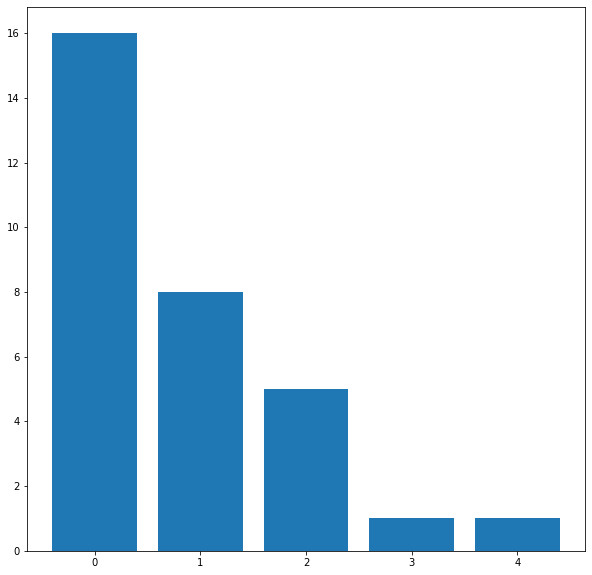

In [170]:
LA_obs_2020 = find_arrival_distribution(start_time_obj, end_time_obj, LA_arrival_info_2020, anchor_contain=False)

Poisson? True , P-value= 0.4967420387472304
Poisson(lambda = 0.806452)


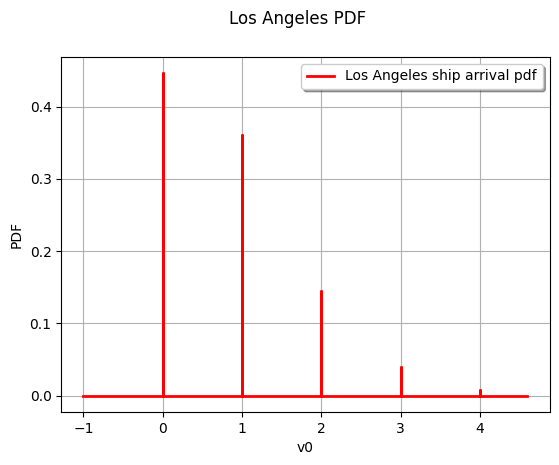

In [171]:
LA_dist = test_fitness(LA_obs_2020)
graph = LA_dist.drawPDF()
graph.setLegends(['Los Angeles ship arrival pdf'])
graph.setTitle('Los Angeles PDF')
view = View(graph, pixelsize=(640,480))
view.show()
# view.save('Los Angeles PDF.png', dpi=100)